In [6]:
import warnings
warnings.filterwarnings("ignore")

import random
import time

import pandas as pd
import numpy as np
import itertools

from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import PipelineModel
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
import pyspark.sql.types as st
import pyspark.sql.functions as sf

from replay.session_handler import State
from replay.metrics import NDCG, Precision, RocAuc
from replay.data_preparator import Indexer

from sim4rec.utils import pandas_to_spark
from sim4rec.modules import SDVDataGenerator, RealDataGenerator
from sim4rec.modules import evaluate_synthetic
from sim4rec.modules import Simulator
from sim4rec.modules import EvaluateMetrics
from sim4rec.utils import VectorElementExtractor
from sim4rec.response import NoiseResponse, CosineSimilatiry
from sim4rec.response import ParametricResponseFunction, BernoulliResponse
from sim4rec.modules import QualityControlObjective

from transformers import ModelCalibration

from replay.models import UCB

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

spark = SparkSession.builder\
    .appName('simulator_ml_quality')\
    .master('local[4]')\
    .config('spark.sql.shuffle.partitions', '4')\
    .config('spark.default.parallelism', '4')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '32g')\
    .config('spark.local.dir', './tmp')\
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')
State(spark)

# Read data

In [137]:
DATA_PATH = r'file:////mnt/dgxhome/home/estavinova/simulator/data/Movielens/'
CHECKPOINTS_DIR = '/data/home/estavinova/tmp/checkpoints/ml_quality_control'
CHECKPOINTS_DIR2='/data/home/estavinova/tmp/checkpoints/movielens_quality_real'
CHECKPOINTS_DIR3='/data/home/estavinova/tmp/checkpoints/movielens_quality_opt'

In [4]:
USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

users_df_train = spark.read.csv(DATA_PATH+'train/users.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv(DATA_PATH+'train/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_train   = spark.read.csv(DATA_PATH+'train/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_train = users_df_train.withColumnRenamed("user_idx", "user_id")
items_df_train = items_df_train.withColumnRenamed("item_idx", "item_id")
log_df_train = log_df_train.withColumnRenamed("user_idx", "user_id")
log_df_train = log_df_train.withColumnRenamed("item_idx", "item_id")

log_df_train = log_df_train.join(users_df_train, log_df_train['user_id'] == users_df_train['user_id'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_id'] == items_df_train['item_id'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_train = items_df_train.na.drop()

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

10000132

In [13]:
users_df_val = spark.read.csv(DATA_PATH+'val/users.csv', header=True, schema=USER_SCHEMA)
items_df_val = spark.read.csv(DATA_PATH+'val/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_val   = spark.read.csv(DATA_PATH+'val/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_val = users_df_val.withColumnRenamed("user_idx", "user_id")
items_df_val = items_df_val.withColumnRenamed("item_idx", "item_id")
log_df_val = log_df_val.withColumnRenamed("user_idx", "user_id")
log_df_val = log_df_val.withColumnRenamed("item_idx", "item_id")

log_df_val = log_df_val.join(users_df_val, log_df_val['user_id'] == users_df_val['user_id'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_id'] == items_df_val['item_id'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_val = items_df_val.na.drop()

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

5000065

In [14]:
users_df_test = spark.read.csv(DATA_PATH+'test/users.csv', header=True, schema=USER_SCHEMA)
items_df_test = spark.read.csv(DATA_PATH+'test/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_test   = spark.read.csv(DATA_PATH+'test/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_test = users_df_test.withColumnRenamed("user_idx", "user_id")
items_df_test = items_df_test.withColumnRenamed("item_idx", "item_id")
log_df_test = log_df_test.withColumnRenamed("user_idx", "user_id")
log_df_test = log_df_test.withColumnRenamed("item_idx", "item_id")

log_df_test = log_df_test.join(users_df_test, log_df_test['user_id'] == users_df_test['user_id'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_id'] == items_df_test['item_id'], 'leftsemi')

for c in users_df_test.columns[1:]:
    users_df_test = users_df_test.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_test.columns[1:]:
    items_df_test = items_df_test.withColumnRenamed(c, 'item_' + c)

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

5000066

# Embeddings generation

In [15]:
%%time
va = VectorAssembler(
    inputCols=users_df_train.columns[1:],
    outputCol='features'
)
pca = PCA(k=9, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(va.transform(users_df_train))
model.explainedVariance

CPU times: user 34.9 ms, sys: 4.01 ms, total: 38.9 ms
Wall time: 6.58 s


DenseVector([0.5139, 0.1649, 0.0891, 0.0435, 0.0366, 0.0279, 0.0189, 0.0136, 0.0108])

In [16]:
%%time
pca_users = model.transform(va.transform(users_df_train)).select(['user_id', 'pca_features'])

pca_users = (pca_users.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_id'] + [col('user_feature')[i] for i in range(9)])
pca_users.toPandas()

CPU times: user 3.01 s, sys: 68.8 ms, total: 3.08 s
Wall time: 5.96 s


,user_id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,1,-3.622775,-0.577107,-0.162202,-0.176447,-0.253122,-0.116941,0.235773,0.264329,0.292615
1,2,-3.961731,-0.617859,-0.131752,-0.185460,-0.139910,0.105091,0.191646,0.156198,0.059740
2,3,-4.084716,-0.625386,-0.236358,-0.193491,-0.118895,0.153699,0.044418,0.267825,-0.053132
3,4,-3.525531,-0.609608,-0.221708,-0.589832,0.169298,0.038561,-0.000828,0.195264,-0.038426
4,5,-4.251370,-0.383833,-0.341450,-0.353603,0.228462,0.070112,0.037554,0.239054,0.008435
...,...,...,...,...,...,...,...,...,...,...
80645,138483,-3.147429,-0.098111,-0.024827,-0.378338,0.148554,0.112192,0.027015,0.193308,-0.003480
80646,138484,-3.287778,-0.394522,-0.021202,-0.499686,0.129370,0.085624,0.015235,0.210864,0.017104
80647,138487,-4.226937,0.019180,-0.178634,-0.431476,0.097237,0.117792,0.046617,0.185198,0.009766
80648,138488,-2.773391,-0.226021,-0.468202,-0.335409,0.403278,-0.101171,0.170729,0.348078,0.041154


In [17]:
%%time
va_it = VectorAssembler(
    inputCols=items_df_train.columns[2:],
    outputCol='features'
)
pca = PCA(k=9, inputCol="features")
pca.setOutputCol("pca_features")
model_it = pca.fit(va_it.transform(items_df_train))
model_it.explainedVariance

CPU times: user 34.9 ms, sys: 8.07 ms, total: 43 ms
Wall time: 2.75 s


DenseVector([0.3812, 0.0605, 0.0511, 0.0405, 0.0377, 0.0259, 0.0223, 0.0193, 0.0186])

In [18]:
%%time
pca_items = model_it.transform(va_it.transform(items_df_train)).select(['item_id', 'pca_features'])

pca_items = (pca_items.withColumn('item_feature', vector_to_array('pca_features'))).select(['item_id'] + [col('item_feature')[i] for i in range(9)])
pca_items.toPandas()


[Stage 48:>                                                         (0 + 4) / 4]



CPU times: user 141 ms, sys: 26.8 ms, total: 167 ms
Wall time: 1.98 s


,item_id,item_feature[0],item_feature[1],item_feature[2],item_feature[3],item_feature[4],item_feature[5],item_feature[6],item_feature[7],item_feature[8]
0,1,-4.108914,-0.392348,0.806751,-0.093269,-0.485105,-0.234772,1.073468,-0.314399,0.443299
1,2,-3.403481,-0.209132,0.211665,0.302370,-0.018620,0.103159,0.954236,-0.034354,0.236430
2,3,-3.340309,-0.707462,0.456691,-0.512297,-0.687214,-0.391139,0.210067,0.629712,0.308934
3,4,-3.042066,-0.476312,-0.290479,-0.459616,-1.368399,-0.468484,0.494244,0.437399,0.826573
4,5,-3.264802,-0.730158,0.503780,-0.205840,-0.536163,-0.285285,0.068718,-0.252822,0.483914
...,...,...,...,...,...,...,...,...,...,...
27079,131254,-0.016437,-0.114364,0.499477,-0.496899,-0.378506,-0.403049,-0.068645,-0.240241,0.136272
27080,131256,-0.016437,-0.114364,0.499477,-0.496899,-0.378506,-0.403049,-0.068645,-0.240241,0.136272
27081,131258,-0.089995,-0.439620,0.090987,0.535330,-0.329515,0.023920,0.745013,-0.053127,0.322798
27082,131260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
%%time
pca_users_val = model.transform(va.transform(users_df_val)).select(['user_id', 'pca_features'])

pca_users_val = (pca_users_val.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_id'] + [col('user_feature')[i] for i in range(9)])
pca_users_val.toPandas()

CPU times: user 2.65 s, sys: 85 ms, total: 2.73 s
Wall time: 5.71 s


,user_id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,1,-3.703400,-0.645062,-0.321042,-0.159401,0.019337,-0.036376,0.057187,0.215621,0.185469
1,2,-3.961731,-0.617859,-0.131752,-0.185460,-0.139910,0.105091,0.191646,0.156198,0.059740
2,3,-4.084716,-0.625386,-0.236358,-0.193491,-0.118895,0.153699,0.044418,0.267825,-0.053132
3,4,-3.525531,-0.609608,-0.221708,-0.589832,0.169298,0.038561,-0.000828,0.195264,-0.038426
4,5,-4.251370,-0.383833,-0.341450,-0.353603,0.228462,0.070112,0.037554,0.239054,0.008435
...,...,...,...,...,...,...,...,...,...,...
106568,138486,-3.754245,-0.594776,-0.276480,-0.323980,-0.118774,-0.139955,0.160285,0.273831,0.185347
106569,138487,-4.226937,0.019180,-0.178634,-0.431476,0.097237,0.117792,0.046617,0.185198,0.009766
106570,138488,-2.773391,-0.226021,-0.468202,-0.335409,0.403278,-0.101171,0.170729,0.348078,0.041154
106571,138490,-3.587840,0.159587,0.228046,-0.235890,0.178379,0.121799,-0.032171,0.095645,-0.086517


In [20]:
%%time
pca_items_val = model_it.transform(va_it.transform(items_df_val)).select(['item_id', 'pca_features'])

pca_items_val = (pca_items_val.withColumn('item_feature', vector_to_array('pca_features'))).select(['item_id'] + [col('item_feature')[i] for i in range(9)])
pca_items_val.toPandas()

CPU times: user 1.25 s, sys: 32.1 ms, total: 1.28 s
Wall time: 2.48 s


,item_id,item_feature[0],item_feature[1],item_feature[2],item_feature[3],item_feature[4],item_feature[5],item_feature[6],item_feature[7],item_feature[8]
0,1,-4.026548,-0.397304,0.806221,-0.091529,-0.489431,-0.235553,1.075512,-0.314614,0.446389
1,2,-3.287642,-0.216102,0.210920,0.304816,-0.024704,0.102062,0.957111,-0.034657,0.240776
2,3,-3.257134,-0.712467,0.456156,-0.510541,-0.691583,-0.391927,0.212132,0.629494,0.312054
3,4,-3.015346,-0.477920,-0.290651,-0.459051,-1.369802,-0.468738,0.494907,0.437329,0.827575
4,5,-3.194526,-0.734386,0.503328,-0.204356,-0.539855,-0.285951,0.070462,-0.253006,0.486550
...,...,...,...,...,...,...,...,...,...,...
27079,131254,-0.016437,-0.114364,0.499477,-0.496899,-0.378506,-0.403049,-0.068645,-0.240241,0.136272
27080,131256,-0.016437,-0.114364,0.499477,-0.496899,-0.378506,-0.403049,-0.068645,-0.240241,0.136272
27081,131258,-0.089995,-0.439620,0.090987,0.535330,-0.329515,0.023920,0.745013,-0.053127,0.322798
27082,131260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
%%time
pca_items_test = model_it.transform(va_it.transform(items_df_test)).select(['item_id', 'pca_features'])

pca_items_test = (pca_items_test.withColumn('item_feature', vector_to_array('pca_features'))).select(['item_id'] + [col('item_feature')[i] for i in range(9)])
pca_items_test.toPandas()

CPU times: user 171 ms, sys: 8.09 ms, total: 179 ms
Wall time: 1.34 s


,item_id,item_feature[0],item_feature[1],item_feature[2],item_feature[3],item_feature[4],item_feature[5],item_feature[6],item_feature[7],item_feature[8]
0,1,-4.017832,-0.436516,0.514398,-0.290600,-0.768937,-0.669060,0.320834,0.433358,0.307032
1,2,-3.273617,-0.247726,0.055557,-0.007878,-0.327438,0.089364,0.483903,0.845774,0.187110
2,3,-3.223180,-0.550955,-0.098369,0.449795,-0.003503,-0.443991,-0.152576,-0.084474,0.283544
3,4,-2.974738,-0.307421,-0.088989,1.179618,-0.374414,-0.895785,-0.231319,0.083784,0.781328
4,5,-3.152596,-0.628406,-0.074024,0.418717,-0.126666,-0.277614,-0.000917,-0.170118,0.274746
...,...,...,...,...,...,...,...,...,...,...
27079,131254,-3.981681,0.232736,-0.052098,0.041546,0.245169,-0.356735,-0.239470,-0.146867,-0.225847
27080,131256,-3.981681,0.232736,-0.052098,0.041546,0.245169,-0.356735,-0.239470,-0.146867,-0.225847
27081,131258,-2.573315,-0.284153,0.052396,0.410075,-0.245121,0.107634,0.229067,-0.013334,0.310750
27082,131260,-2.984801,0.179601,0.019200,-0.063036,0.156784,0.028288,-0.074074,0.007811,-0.111964


Создадим набор данных, который впоследствии сделаем полным.

In [50]:
users_df_comp = pca_users.limit(10000)
items_df_comp = pca_items.limit(2000)
log_df_full = users_df_comp.crossJoin(items_df_comp)

log_df_comp = log_df_full.join(log_df_train, on=['user_id', 'item_id'], how='leftanti')
log_df_comp = log_df_comp.join(log_df_val, on=['user_id', 'item_id'], how='leftanti')
log_df_comp = log_df_comp.join(log_df_test, on=['user_id', 'item_id'], how='leftanti')

In [51]:
log_df_comp.count()

19169031

# Generator learning

In [91]:
%%time
generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)
generator_1.fit(users_df_comp.drop('user_id'))
items_generator.fit(items_df_comp)

CPU times: user 274 ms, sys: 8.96 ms, total: 283 ms
Wall time: 2.04 s


In [92]:
real_users = users_df_comp
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_id')
)
print(gen_score)

{'LogisticDetection': 0.9881423055322929, 'SVCDetection': 0.29116611661040126, 'KSTest': 0.9592111111111112, 'ContinuousKLDivergence': 0.9423389088336714}


# Response model training

In [33]:
va = VectorAssembler(
    inputCols=pca_users.columns[1:] + pca_items.columns[1:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

In [34]:
train_df = log_df_val.join(pca_users, 'user_id', 'left')\
                       .join(pca_items, 'item_id', 'left')\
                       .drop('timestamp')
train_df = train_df.na.drop()

In [35]:
%%time
lr_model = lr.fit(va.transform(train_df))

CPU times: user 35.3 ms, sys: 401 µs, total: 35.7 ms
Wall time: 22.9 s


# Parametric response model

In [37]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='__r2', seed=1234)

va_users = VectorAssembler(
    inputCols=pca_users.columns[1:],
    outputCol='features_usr'
)

va_items = VectorAssembler(
    inputCols=pca_items.columns[1:],
    outputCol='features_itm'
)

heur_resp = CosineSimilatiry(inputCols=['features_usr', 'features_itm'], outputCol='__r3')

resp_func = ParametricResponseFunction(
    inputCols=['__r1', '__r2', '__r3'],
    outputCol='__proba',
    weights=[1.0, 0.0, 0.0]
)

mc = ModelCalibration(inputCol='__proba', outputCol='__mc', value=0.25)

br = BernoulliResponse(inputCol='__mc', outputCol='response', seed=1234)

pipeline = PipelineModel(
    stages=[
        va,
        lr_model,
        vee,
        noise_resp,
        va_users,
        va_items,
        heur_resp,
        resp_func,
        mc,
        br
    ]
)

Создадим полный датасет.

In [79]:
log_df_comp = log_df_comp.drop('timestamp')

pred_df = pipeline.transform(log_df_comp)
pred_df = pred_df.select('user_id', 'item_id', 'response').withColumnRenamed('response', 'relevance')

In [77]:
log_df_ex1 = log_df_full.join(log_df_train, on=['user_id', 'item_id'], how='inner')
log_df_ex2 = log_df_full.join(log_df_val, on=['user_id', 'item_id'], how='inner')
log_df_ex3 = log_df_full.join(log_df_test, on=['user_id', 'item_id'], how='inner')
log_df_ex = log_df_ex1.union(log_df_ex2).union(log_df_ex3).select('user_id', 'item_id', 'relevance')

In [80]:
pred_df = pred_df.union(log_df_ex)

In [81]:
pred_df.count()

20000000

In [107]:
sim = Simulator(
    user_gen=generator_1,
    item_gen=items_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR,
)

In [108]:
sim_real = Simulator(
    user_gen=generator_1,
    item_gen=items_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR2,
)

In [84]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10, Precision() : 10, RocAuc(): 10}
)

In [109]:
%%time
real_indexer = Indexer(user_col='user_id', item_col='item_id')
real_indexer.fit(users=pca_users, items=pca_items)

synth_indexer = Indexer(user_col='user_id', item_col='item_id')
synth_indexer.fit(users=generator_1.sample(1.0), items=pca_items_val)

real_model = UCB(sample = True)
simulator_model = UCB(sample = True)

real_model.fit(log=synth_indexer.transform(log_df_val.drop('timestamp').limit(1)))
simulator_model.fit(log=synth_indexer.transform(log_df_val.drop('timestamp').limit(1)))

CPU times: user 1.1 s, sys: 289 ms, total: 1.39 s
Wall time: 1min 23s


# Real model training

In [110]:
%%time

ndcg = NDCG()
precision = Precision()

LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)

real_learning_metrics = []
items_replay = real_indexer.transform(items_df_comp).cache()

resp_func.setWeights([0.5, 0.5, 0.0])

for i in range(30):
    print(f'Stage {i}')
    start_iter = time.time()
    log = sim_real.log
    if log is None:
        log = empty_log
    log = log.cache()
    users = users_df_comp.sample(0.02).cache()

    recs = real_model.predict(
        log=real_indexer.transform(log),
        k=10,
        users=real_indexer.transform(users),
        items=items_replay
    )
    recs = real_indexer.inverse_transform(recs).cache()
    
    true_resp = pred_df.withColumnRenamed('relevance', 'response')\
        .join(recs, on=['user_id', 'item_id'], how='inner').drop('timestamp').cache()
    
    sim_real.update_log(true_resp, iteration=i)
    
    real_learning_metrics.append(evaluator(true_resp))

    real_model._clear_cache()
    train_log = sim_real.log.cache()
    real_model.fit(
        log=real_indexer.transform(
            train_log.select('user_id', 'item_id', 'response')\
                .withColumnRenamed('response', 'relevance')
        )
    )
        
    users.unpersist()
    train_log.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    end_iter = time.time()
    print(f"Time of {i} iteration: ")
    print(end_iter - start_iter)

log = sim_real.log.cache()
users = users_df_comp.sample(0.2).cache()

real_recs = real_model.predict(
    log=real_indexer.transform(log),
    k=10,
    users=real_indexer.transform(users),
    items=items_replay
)
real_recs = real_indexer.inverse_transform(real_recs).cache()

real_ground_truth = pred_df.withColumnRenamed('relevance', 'response')\
    .join(real_recs, on=['user_id', 'item_id'], how='inner').drop('timestamp').cache()

real_final_metrics = evaluator(real_ground_truth)

items_replay.unpersist()

Stage 0


Time of 0 iteration: 
491.09450030326843
Stage 1


Time of 1 iteration: 
593.4182353019714
Stage 2


Time of 2 iteration: 
393.66126799583435
Stage 3


Time of 3 iteration: 
411.34674859046936
Stage 4


Time of 4 iteration: 
377.4309732913971
Stage 5


Time of 5 iteration: 
352.13058590888977
Stage 6


Time of 6 iteration: 
294.55312633514404
Stage 7


Time of 7 iteration: 
296.10899329185486
Stage 8


Time of 8 iteration: 
298.0825254917145
Stage 9


Time of 9 iteration: 
287.2294850349426
Stage 10


Time of 10 iteration: 
292.08033323287964
Stage 11


Time of 11 iteration: 
327.54464983940125
Stage 12


Time of 12 iteration: 
290.05182695388794
Stage 13


Time of 13 iteration: 
285.3420920372009
Stage 14


Time of 14 iteration: 
293.1998755931854
Stage 15


Time of 15 iteration: 
296.9593107700348
Stage 16


Time of 16 iteration: 
297.79289984703064
Stage 17


Time of 17 iteration: 
290.90799617767334
Stage 18


Time of 18 iteration: 
291.54216170310974
Stage 19


Time of 19 iteration: 
285.6636793613434
Stage 20


Time of 20 iteration: 
286.71636605262756
Stage 21


Time of 21 iteration: 
290.691876411438
Stage 22


Time of 22 iteration: 
288.6290965080261
Stage 23


Time of 23 iteration: 
286.69846272468567
Stage 24


Time of 24 iteration: 
295.9634380340576
Stage 25


Time of 25 iteration: 
295.66212034225464
Stage 26


Time of 26 iteration: 
297.4917449951172
Stage 27


Time of 27 iteration: 
281.5640299320221
Stage 28


Time of 28 iteration: 
291.5344588756561
Stage 29


Time of 29 iteration: 
286.8751902580261


CPU times: user 2min 32s, sys: 34 s, total: 3min 6s
Wall time: 2h 45min 42s


DataFrame[item_feature[0]: double, item_feature[1]: double, item_feature[2]: double, item_feature[3]: double, item_feature[4]: double, item_feature[5]: double, item_feature[6]: double, item_feature[7]: double, item_feature[8]: double, item_idx: int]

In [111]:
real_final_metrics

{'NDCG@10': 0.6257653717618089,
 'Precision@10': 0.2710636079249216,
 'RocAuc@10': 0.5292636178559014}

# Synthetic model training (in simulator)

Как и в предыдущих экспериментах, обучаем модель UCB с помощью симулятора на синтетических данных.

In [114]:
LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)

items_replay = synth_indexer.transform(items_df_comp).cache()

ucb_metrics_old = []

for i in range(30):
    iter_start = time.time()

    users = sim.sample_users(0.02).cache()
    
    log = sim.get_log(users)
    if log is None:
        log = empty_log
    log = log.cache()

    recs_ucb = simulator_model.predict(
        log=synth_indexer.transform(log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
    recs_ucb = synth_indexer.inverse_transform(recs_ucb).cache()

    resp_ucb = sim.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items_df_comp,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    sim.update_log(resp_ucb, iteration=i)

    ucb_metrics_old.append(evaluator(resp_ucb))

    simulator_model._clear_cache()
    ucb_train_log = sim.log.cache()
    simulator_model.fit(
        log=synth_indexer.transform(
            ucb_train_log\
                .select('user_id', 'item_id', 'response')\
                .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    resp_ucb.unpersist()
    ucb_train_log.unpersist()

    print(f'Iteration {i} finished with time {time.time() - iter_start} sec.')
    
users = sim.sample_users(0.2).cache()
synth_recs = synth_indexer.inverse_transform(
    simulator_model.predict(
        log=synth_indexer.transform(sim.log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
).cache()
synth_ground_truth = sim.sample_responses(
    recs_df=synth_recs,
    user_features=users,
    item_features=items_df_comp,
    action_models=pipeline
).select('user_id', 'item_id', 'relevance', 'response').cache()
final_metrics = evaluator(synth_ground_truth)

items_replay.unpersist()

Iteration 0 finished with time 26.233932495117188 sec.
Iteration 1 finished with time 19.581873178482056 sec.



[Stage 9012:>                                                       (0 + 4) / 4]



Iteration 2 finished with time 19.51755428314209 sec.
Iteration 3 finished with time 19.80730438232422 sec.
Iteration 4 finished with time 19.658565282821655 sec.
Iteration 5 finished with time 18.993682622909546 sec.
Iteration 6 finished with time 19.63825559616089 sec.


Iteration 7 finished with time 19.731723070144653 sec.
Iteration 8 finished with time 19.370787858963013 sec.
Iteration 9 finished with time 20.188329458236694 sec.


Iteration 10 finished with time 19.651352882385254 sec.


Iteration 11 finished with time 20.92009210586548 sec.


Iteration 12 finished with time 20.744285821914673 sec.
Iteration 13 finished with time 20.639321088790894 sec.
Iteration 14 finished with time 21.07686495780945 sec.


Iteration 15 finished with time 20.56736421585083 sec.
Iteration 16 finished with time 19.316908597946167 sec.
Iteration 17 finished with time 19.331665992736816 sec.
Iteration 18 finished with time 19.11871314048767 sec.
Iteration 19 finished with time 19.57170796394348 sec.


Iteration 20 finished with time 26.231399297714233 sec.


Iteration 21 finished with time 19.14513874053955 sec.
Iteration 22 finished with time 19.37420916557312 sec.
Iteration 23 finished with time 19.97400736808777 sec.
Iteration 24 finished with time 20.30391240119934 sec.
Iteration 25 finished with time 19.89417862892151 sec.
Iteration 26 finished with time 19.704529762268066 sec.


Iteration 27 finished with time 20.490021228790283 sec.


Iteration 28 finished with time 20.898277521133423 sec.
Iteration 29 finished with time 20.062936305999756 sec.


DataFrame[item_feature[0]: double, item_feature[1]: double, item_feature[2]: double, item_feature[3]: double, item_feature[4]: double, item_feature[5]: double, item_feature[6]: double, item_feature[7]: double, item_feature[8]: double, item_idx: int]

In [115]:
final_metrics

{'NDCG@10': 0.533969593671985,
 'Precision@10': 0.19638554216867485,
 'RocAuc@10': 0.4878339434836856}

Проверим на реальных данных качество рексистемы, обученной на синтетике.

In [116]:
items_replay = real_indexer.transform(items_df_comp).cache()
log = sim.log.cache()
users = users_df_comp.sample(0.02).cache()

real_recs = simulator_model.predict(
    log=synth_indexer.transform(log),
    k=10,
    users=real_indexer.transform(users),
    items=items_replay
)
real_recs = real_indexer.inverse_transform(real_recs).cache()

real_ground_truth = pred_df.withColumnRenamed('relevance', 'response')\
    .join(real_recs, on=['user_id', 'item_id'], how='inner').drop('timestamp').cache()

real_metrics_trained_on_synth = evaluator(real_ground_truth)
items_replay.unpersist()

DataFrame[item_feature[0]: double, item_feature[1]: double, item_feature[2]: double, item_feature[3]: double, item_feature[4]: double, item_feature[5]: double, item_feature[6]: double, item_feature[7]: double, item_feature[8]: double, item_idx: int]

In [117]:
real_metrics_trained_on_synth

{'NDCG@10': 0.5914915560215628,
 'Precision@10': 0.255609756097561,
 'RocAuc@10': 0.48394657375145184}

И наоборот: проверим на синтетических данных качество рексистемы, обученной на реальных.

In [118]:
items_replay = real_indexer.transform(items_df_comp).cache()
users = sim.sample_users(0.02).cache()
synth_recs = synth_indexer.inverse_transform(
    real_model.predict(
        log=real_indexer.transform(sim_real.log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
).cache()
synth_ground_truth = sim.sample_responses(
    recs_df=synth_recs,
    user_features=users,
    item_features=items_df_comp,
    action_models=pipeline
).select('user_id', 'item_id', 'relevance', 'response').cache()
synth_metrics_trained_on_real = evaluator(synth_ground_truth)
items_replay.unpersist()

DataFrame[item_feature[0]: double, item_feature[1]: double, item_feature[2]: double, item_feature[3]: double, item_feature[4]: double, item_feature[5]: double, item_feature[6]: double, item_feature[7]: double, item_feature[8]: double, item_idx: int]

In [119]:
synth_metrics_trained_on_real

{'NDCG@10': 0.5583396475236223,
 'Precision@10': 0.1999999999999999,
 'RocAuc@10': 0.49805873995688804}

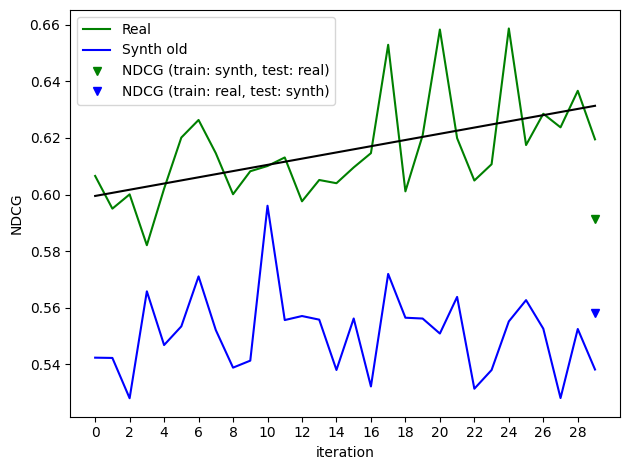

In [126]:
def draw_trend(x, y):
    trend = np.polyfit(x, y, 1)
    result = trend[0]*x + trend[1]
    return result

real_learning_metrics_pdf = pd.DataFrame(real_learning_metrics)
ucb_metrics_old_pdf = pd.DataFrame(ucb_metrics_old)

plt.plot(real_learning_metrics_pdf['NDCG@10'], color='g', label='Real')
plt.plot(draw_trend(range(30), real_learning_metrics_pdf['NDCG@10']), color='k')
plt.plot(ucb_metrics_old_pdf['NDCG@10'], color='b', label='Synth old')

plt.plot(29, real_metrics_trained_on_synth['NDCG@10'], 'gv', label='NDCG (train: synth, test: real)')
plt.plot(29, synth_metrics_trained_on_real['NDCG@10'], 'bv', label='NDCG (train: real, test: synth)')

plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.legend()
plt.xticks(np.arange(0, 30, step=2.0))
plt.tight_layout()
#plt.savefig('ml_qual_sber.png', dpi=300)

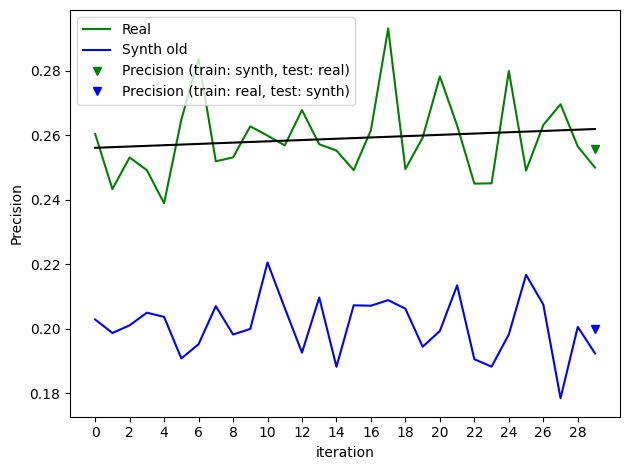

In [128]:
plt.plot(real_learning_metrics_pdf['Precision@10'], color='g', label='Real')
plt.plot(draw_trend(range(30), real_learning_metrics_pdf['Precision@10']), color='k')
plt.plot(ucb_metrics_old_pdf['Precision@10'], color='b', label='Synth old')

plt.plot(29, real_metrics_trained_on_synth['Precision@10'], 'gv', label='Precision (train: synth, test: real)')
plt.plot(29, synth_metrics_trained_on_real['Precision@10'], 'bv', label='Precision (train: real, test: synth)')

plt.xlabel('iteration')
plt.ylabel('Precision')
plt.legend()
plt.xticks(np.arange(0, 30, step=2.0))
plt.tight_layout()

# Objective function optimization

In [ ]:
qco = QualityControlObjective(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    relevanceCol='relevance',
    response_function=pipeline,
    replay_metrics={NDCG() : 10, Precision() : 10}
)

LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)
pred_df_sample = pred_df.sample(0.1)

DISC = 10
manifold = []
for a1 in range(DISC + 1):
    for a2 in range(DISC - a1 + 1):
        a3 = DISC - a1 - a2

        a_sum = a1 + a2 + a3
        manifold.append([a1 / a_sum, a2 / a_sum, a3 / a_sum])

obj = []
items_replay = synth_indexer.transform(items_df_comp).cache()
for alphas in manifold:
    print(f'Current alpha : {alphas}')

    sim.clear_log()
    sim.log_filename = f'log_{"_".join([str(a) for a in alphas])}.parquet'
    resp_func.setWeights(alphas)

    for i in range(30):
        print(f'Stage {i}')
        start_iter = time.time()
        users = sim.sample_users(0.02).cache()

        log = sim.get_log(users)
        if log is None:
            log = empty_log
        log = log.cache()

        recs = simulator_model.predict(
            log=synth_indexer.transform(log),
            k=10,
            users=synth_indexer.transform(users),
            items=items_replay
        )
        recs = synth_indexer.inverse_transform(recs)

        true_resp = sim.sample_responses(
            recs_df=recs,
            user_features=users,
            item_features=items_df_comp,
            action_models=pipeline
        ).select('user_id', 'item_id', 'relevance', 'response')

        sim.update_log(true_resp, iteration=i)

        simulator_model._clear_cache()
        train_log = sim.log.cache()
        simulator_model.fit(
            log=synth_indexer.transform(
                train_log.select('user_id', 'item_id', 'response')\
                         .withColumnRenamed('response', 'relevance')
            )
        )

        users.unpersist()
        if log is not None:
            log.unpersist()
        train_log.unpersist()
        end_iter = time.time()
        print(f"Time of {i} iteration: ")
        print(end_iter - start_iter)

    users = sim.sample_users(0.02)
    synth_recs = synth_indexer.inverse_transform(
        simulator_model.predict(
            log=synth_indexer.transform(sim.log),
            k=10,
            users=synth_indexer.transform(users),
            items=items_replay
        )
    )
    synth_ground_truth = sim.sample_responses(
        recs_df=synth_recs,
        user_features=users,
        item_features=items_df_comp,
        action_models=pipeline
    ).select('user_id', 'item_id', 'response')\
     .withColumnRenamed('response', 'relevance')\
     .filter(sf.col('relevance') == 1)
    
    obj.append(
        qco(
            test_log=pred_df_sample,
            user_features=users_df_comp,
            item_features=items_df_comp,
            real_recs=real_recs,
            real_ground_truth=real_ground_truth,
            synthetic_recs=synth_recs,
            synthetic_ground_truth=synth_ground_truth
        )
    )

Current alpha : [0.0, 0.0, 1.0]
Stage 0


Time of 0 iteration: 
16.752711057662964
Stage 1


Time of 1 iteration: 
15.712963104248047
Stage 2



[Stage 13188:>                                                      (0 + 4) / 4]



Time of 2 iteration: 
14.432903289794922
Stage 3


Time of 3 iteration: 
15.098358154296875
Stage 4
Time of 4 iteration: 
15.107399463653564
Stage 5


Time of 5 iteration: 
14.9564847946167
Stage 6


Time of 6 iteration: 
14.339978694915771
Stage 7
Time of 7 iteration: 
14.307445764541626
Stage 8
Time of 8 iteration: 
14.587472200393677
Stage 9


Time of 9 iteration: 
15.682271242141724
Stage 10
Time of 10 iteration: 
15.551124095916748
Stage 11


Time of 11 iteration: 
15.164228677749634
Stage 12
Time of 12 iteration: 
15.803000450134277
Stage 13


Time of 13 iteration: 
15.68030595779419
Stage 14
Time of 14 iteration: 
15.740267038345337
Stage 15
Time of 15 iteration: 
15.91910195350647
Stage 16
Time of 16 iteration: 
15.707726240158081
Stage 17
Time of 17 iteration: 
15.96371865272522
Stage 18


Time of 18 iteration: 
15.99546194076538
Stage 19


Time of 19 iteration: 
15.895381689071655
Stage 20


Time of 20 iteration: 
15.813839435577393
Stage 21


Time of 21 iteration: 
15.968364953994751
Stage 22



[Stage 14648:=============>                                         (1 + 3) / 4]



Time of 22 iteration: 
15.83122968673706
Stage 23


Time of 23 iteration: 
16.730961084365845
Stage 24


Time of 24 iteration: 
16.01634645462036
Stage 25


Time of 25 iteration: 
16.381489276885986
Stage 26


Time of 26 iteration: 
16.339985132217407
Stage 27
Time of 27 iteration: 
15.935357332229614
Stage 28
Time of 28 iteration: 
16.112403631210327
Stage 29


Time of 29 iteration: 
15.913851261138916


Current alpha : [0.0, 0.1, 0.9]
Stage 0
Time of 0 iteration: 
13.676395416259766
Stage 1
Time of 1 iteration: 
14.724708080291748
Stage 2
Time of 2 iteration: 
14.281186819076538
Stage 3
Time of 3 iteration: 
14.165992975234985
Stage 4
Time of 4 iteration: 
14.825519323348999
Stage 5


Time of 5 iteration: 
14.840460777282715
Stage 6
Time of 6 iteration: 
15.23607850074768
Stage 7
Time of 7 iteration: 
15.421740770339966
Stage 8
Time of 8 iteration: 
15.35449767112732
Stage 9


Time of 9 iteration: 
15.163046598434448
Stage 10
Time of 10 iteration: 
15.011488199234009
Stage 11


Time of 11 iteration: 
15.456842422485352
Stage 12


Time of 12 iteration: 
15.465660572052002
Stage 13
Time of 13 iteration: 
15.399626731872559
Stage 14
Time of 14 iteration: 
15.594023704528809
Stage 15


Time of 15 iteration: 
15.762754201889038
Stage 16


Time of 16 iteration: 
16.193554162979126
Stage 17


Time of 17 iteration: 
16.326724767684937
Stage 18


Time of 18 iteration: 
16.058490991592407
Stage 19


Time of 19 iteration: 
15.554380178451538
Stage 20
Time of 20 iteration: 
16.03652811050415
Stage 21


Time of 21 iteration: 
16.056209564208984
Stage 22
Time of 22 iteration: 
15.97689962387085
Stage 23


Time of 23 iteration: 
16.724008798599243
Stage 24


Time of 24 iteration: 
17.13979697227478
Stage 25



[Stage 17256:===========================>                           (2 + 2) / 4]



Time of 25 iteration: 
17.12449812889099
Stage 26



[Stage 17329:===========================>                           (2 + 2) / 4]



Time of 26 iteration: 
16.184794664382935
Stage 27


Time of 27 iteration: 
17.129851579666138
Stage 28


Time of 28 iteration: 
16.983314514160156
Stage 29
Time of 29 iteration: 
16.753240823745728


Current alpha : [0.0, 0.2, 0.8]
Stage 0
Time of 0 iteration: 
13.062156677246094
Stage 1
Time of 1 iteration: 
14.09664797782898
Stage 2
Time of 2 iteration: 
14.78380799293518
Stage 3
Time of 3 iteration: 
14.41332721710205
Stage 4



[Stage 18112:=========================================>             (3 + 1) / 4]



Time of 4 iteration: 
14.635344743728638
Stage 5
Time of 5 iteration: 
14.27989649772644
Stage 6
Time of 6 iteration: 
15.101073265075684
Stage 7
Time of 7 iteration: 
15.363267660140991
Stage 8


Time of 8 iteration: 
15.047043561935425
Stage 9


Time of 9 iteration: 
15.341558456420898
Stage 10



[Stage 18550:===========================>                           (2 + 2) / 4]



Time of 10 iteration: 
15.244892358779907
Stage 11
Time of 11 iteration: 
15.563448905944824
Stage 12
Time of 12 iteration: 
15.328272819519043
Stage 13
Time of 13 iteration: 
15.76148271560669
Stage 14


Time of 14 iteration: 
15.457528591156006
Stage 15



[Stage 18915:>                                                      (0 + 4) / 4]



Time of 15 iteration: 
15.93388056755066
Stage 16


Time of 16 iteration: 
15.72983455657959
Stage 17
Time of 17 iteration: 
16.13502550125122
Stage 18
Time of 18 iteration: 
15.754587411880493
Stage 19


Time of 19 iteration: 
16.057667016983032
Stage 20


Time of 20 iteration: 
16.18552589416504
Stage 21


Time of 21 iteration: 
15.864008665084839
Stage 22
Time of 22 iteration: 
16.79220461845398
Stage 23



[Stage 19499:===========================>                           (2 + 2) / 4]



Time of 23 iteration: 
16.63018035888672
Stage 24


Time of 24 iteration: 
16.73686408996582
Stage 25
Time of 25 iteration: 
16.740991830825806
Stage 26
Time of 26 iteration: 
16.98202896118164
Stage 27
Time of 27 iteration: 
17.48911476135254
Stage 28
Time of 28 iteration: 
16.952516317367554
Stage 29



[Stage 19937:=============>                                         (1 + 3) / 4]



Time of 29 iteration: 
17.2547767162323


Current alpha : [0.0, 0.3, 0.7]
Stage 0
Time of 0 iteration: 
13.740559339523315
Stage 1
Time of 1 iteration: 
14.362894535064697
Stage 2


Time of 2 iteration: 
14.420575618743896
Stage 3


Time of 3 iteration: 
14.954086780548096
Stage 4
Time of 4 iteration: 
14.804970026016235
Stage 5
Time of 5 iteration: 
15.171951293945312
Stage 6


Time of 6 iteration: 
15.803224563598633
Stage 7


Time of 7 iteration: 
15.298819303512573
Stage 8
Time of 8 iteration: 
15.34304690361023
Stage 9
Time of 9 iteration: 
15.369645118713379
Stage 10
Time of 10 iteration: 
15.857204675674438
Stage 11


Time of 11 iteration: 
15.193297624588013
Stage 12
Time of 12 iteration: 
15.049065828323364
Stage 13
Time of 13 iteration: 
15.573325872421265
Stage 14


Time of 14 iteration: 
15.4649076461792
Stage 15


Time of 15 iteration: 
15.902329921722412
Stage 16
Time of 16 iteration: 
16.065744638442993
Stage 17


Time of 17 iteration: 
15.706432580947876
Stage 18
Time of 18 iteration: 
16.13442635536194
Stage 19
Time of 19 iteration: 
15.514330863952637
Stage 20


Time of 20 iteration: 
15.862889528274536
Stage 21


Time of 21 iteration: 
16.38381290435791
Stage 22
Time of 22 iteration: 
16.30463433265686
Stage 23
Time of 23 iteration: 
16.794635772705078
Stage 24
Time of 24 iteration: 
16.522544622421265
Stage 25


Time of 25 iteration: 
16.85701036453247
Stage 26


Time of 26 iteration: 
17.02818012237549
Stage 27


Time of 27 iteration: 
17.223270654678345
Stage 28


Time of 28 iteration: 
17.405147790908813
Stage 29


Time of 29 iteration: 
17.584425926208496


Current alpha : [0.0, 0.4, 0.6]
Stage 0
Time of 0 iteration: 
14.216112852096558
Stage 1
Time of 1 iteration: 
14.51083254814148
Stage 2
Time of 2 iteration: 
14.284695625305176
Stage 3
Time of 3 iteration: 
14.589977979660034
Stage 4
Time of 4 iteration: 
14.305652141571045
Stage 5
Time of 5 iteration: 
14.242334365844727
Stage 6
Time of 6 iteration: 
14.605103492736816
Stage 7
Time of 7 iteration: 
15.496429443359375
Stage 8
Time of 8 iteration: 
15.091581583023071
Stage 9


Time of 9 iteration: 
15.91087818145752
Stage 10
Time of 10 iteration: 
15.108764410018921
Stage 11
Time of 11 iteration: 
15.556757926940918
Stage 12


Time of 12 iteration: 
20.89657497406006
Stage 13
Time of 13 iteration: 
14.927610158920288
Stage 14


Time of 14 iteration: 
14.76863718032837
Stage 15
Time of 15 iteration: 
14.827982902526855
Stage 16
Time of 16 iteration: 
15.042355298995972
Stage 17
Time of 17 iteration: 
15.010633707046509
Stage 18


Time of 18 iteration: 
15.530333042144775
Stage 19


Time of 19 iteration: 
15.286994695663452
Stage 20


Time of 20 iteration: 
16.053735733032227
Stage 21


Time of 21 iteration: 
15.387096405029297
Stage 22
Time of 22 iteration: 
15.88631272315979
Stage 23


Time of 23 iteration: 
15.673402547836304
Stage 24
Time of 24 iteration: 
15.088570833206177
Stage 25


Time of 25 iteration: 
15.53185486793518
Stage 26


Time of 26 iteration: 
16.16706371307373
Stage 27


Time of 27 iteration: 
15.906105756759644
Stage 28


Time of 28 iteration: 
16.164246559143066
Stage 29


Time of 29 iteration: 
16.36025333404541


Current alpha : [0.0, 0.5, 0.5]
Stage 0
Time of 0 iteration: 
13.935728788375854
Stage 1
Time of 1 iteration: 
13.7284677028656
Stage 2



[Stage 25133:>                                                      (0 + 4) / 4]



Time of 2 iteration: 
14.512823581695557
Stage 3


Time of 3 iteration: 
14.461727142333984
Stage 4
Time of 4 iteration: 
14.450678586959839
Stage 5
Time of 5 iteration: 
15.288843870162964
Stage 6


Time of 6 iteration: 
15.595252990722656
Stage 7
Time of 7 iteration: 
15.347042083740234
Stage 8
Time of 8 iteration: 
14.905960321426392
Stage 9
Time of 9 iteration: 
15.395676612854004
Stage 10
Time of 10 iteration: 
16.00005078315735
Stage 11
Time of 11 iteration: 
15.690001010894775
Stage 12
Time of 12 iteration: 
16.060200929641724
Stage 13
Time of 13 iteration: 
15.59482455253601
Stage 14


Time of 14 iteration: 
15.959350347518921
Stage 15
Time of 15 iteration: 
16.13201355934143
Stage 16
Time of 16 iteration: 
16.52972149848938
Stage 17


Time of 17 iteration: 
16.16038489341736
Stage 18
Time of 18 iteration: 
15.805171489715576
Stage 19
Time of 19 iteration: 
16.77061653137207
Stage 20
Time of 20 iteration: 
15.735187530517578
Stage 21



[Stage 26520:===========================>                           (2 + 2) / 4]



Time of 21 iteration: 
15.71339225769043
Stage 22


Time of 22 iteration: 
16.916781663894653
Stage 23


Time of 23 iteration: 
16.878584623336792
Stage 24


Time of 24 iteration: 
16.863903999328613
Stage 25
Time of 25 iteration: 
16.485374927520752
Stage 26
Time of 26 iteration: 
16.89730477333069
Stage 27


Time of 27 iteration: 
16.86074924468994
Stage 28
Time of 28 iteration: 
16.766265869140625
Stage 29


Time of 29 iteration: 
16.738600254058838


Current alpha : [0.0, 0.6, 0.4]
Stage 0
Time of 0 iteration: 
13.65510630607605
Stage 1
Time of 1 iteration: 
14.303060531616211
Stage 2
Time of 2 iteration: 
14.446057081222534
Stage 3
Time of 3 iteration: 
14.936990022659302
Stage 4
Time of 4 iteration: 
15.079594373703003
Stage 5


Time of 5 iteration: 
15.081943988800049
Stage 6
Time of 6 iteration: 
15.191749572753906
Stage 7
Time of 7 iteration: 
15.463115215301514
Stage 8
Time of 8 iteration: 
15.371503353118896
Stage 9
Time of 9 iteration: 
15.061158895492554
Stage 10


Time of 10 iteration: 
16.033488988876343
Stage 11


Time of 11 iteration: 
15.984662055969238
Stage 12
Time of 12 iteration: 
15.851759672164917
Stage 13
Time of 13 iteration: 
16.545112371444702
Stage 14
Time of 14 iteration: 
15.823339223861694
Stage 15
Time of 15 iteration: 
15.659186124801636
Stage 16


Time of 16 iteration: 
15.065920352935791
Stage 17


Time of 17 iteration: 
15.687249422073364
Stage 18


Time of 18 iteration: 
16.00431513786316
Stage 19


Time of 19 iteration: 
16.071826934814453
Stage 20


Time of 20 iteration: 
16.35077428817749
Stage 21
Time of 21 iteration: 
16.20744252204895
Stage 22
Time of 22 iteration: 
16.315815687179565
Stage 23


Time of 23 iteration: 
15.755830764770508
Stage 24



[Stage 29130:>                                                      (0 + 4) / 4]



Time of 24 iteration: 
15.774609327316284
Stage 25
Time of 25 iteration: 
15.885021209716797
Stage 26


Time of 26 iteration: 
16.36863875389099
Stage 27
Time of 27 iteration: 
15.854249000549316
Stage 28


Time of 28 iteration: 
16.050785541534424
Stage 29


Time of 29 iteration: 
16.04685068130493


Current alpha : [0.0, 0.7, 0.3]
Stage 0
Time of 0 iteration: 
13.742030143737793
Stage 1
Time of 1 iteration: 
14.740372896194458
Stage 2
Time of 2 iteration: 
14.455439329147339
Stage 3
Time of 3 iteration: 
14.414170742034912
Stage 4
Time of 4 iteration: 
14.588940382003784
Stage 5
Time of 5 iteration: 
14.982353210449219
Stage 6


Time of 6 iteration: 
14.838898420333862
Stage 7
Time of 7 iteration: 
15.12434697151184
Stage 8
Time of 8 iteration: 
15.480804681777954
Stage 9
Time of 9 iteration: 
15.349562168121338
Stage 10


Time of 10 iteration: 
15.457340002059937
Stage 11


Time of 11 iteration: 
15.862056732177734
Stage 12
Time of 12 iteration: 
15.59955358505249
Stage 13


Time of 13 iteration: 
15.887861967086792
Stage 14


Time of 14 iteration: 
15.736839056015015
Stage 15



[Stage 30860:>                                                      (0 + 4) / 4]



Time of 15 iteration: 
15.737898111343384
Stage 16
Time of 16 iteration: 
15.682387113571167
Stage 17



[Stage 31006:=============>                                         (1 + 3) / 4]



Time of 17 iteration: 
15.985138416290283
Stage 18


Time of 18 iteration: 
15.955470323562622
Stage 19
Time of 19 iteration: 
16.00480890274048
Stage 20
Time of 20 iteration: 
16.17973279953003
Stage 21
Time of 21 iteration: 
16.50355362892151
Stage 22
Time of 22 iteration: 
16.59585404396057
Stage 23


Time of 23 iteration: 
16.70462656021118
Stage 24


Time of 24 iteration: 
16.676626205444336
Stage 25


Time of 25 iteration: 
16.04763150215149
Stage 26



[Stage 31663:>                                                      (0 + 4) / 4]



Time of 26 iteration: 
16.18537664413452
Stage 27


Time of 27 iteration: 
16.249633312225342
Stage 28


Time of 28 iteration: 
17.031890869140625
Stage 29
Time of 29 iteration: 
16.677427291870117


Current alpha : [0.0, 0.8, 0.2]
Stage 0
Time of 0 iteration: 
13.225735187530518
Stage 1
Time of 1 iteration: 
14.972595691680908
Stage 2
Time of 2 iteration: 
14.4785737991333
Stage 3
Time of 3 iteration: 
14.376507043838501
Stage 4
Time of 4 iteration: 
14.577357053756714
Stage 5
Time of 5 iteration: 
15.360026121139526
Stage 6


Time of 6 iteration: 
14.91817593574524
Stage 7
Time of 7 iteration: 
15.153984546661377
Stage 8


Time of 8 iteration: 
15.060860633850098
Stage 9
Time of 9 iteration: 
15.4732027053833
Stage 10


Time of 10 iteration: 
15.574437618255615
Stage 11


Time of 11 iteration: 
15.118665218353271
Stage 12


Time of 12 iteration: 
15.82949185371399
Stage 13
Time of 13 iteration: 
15.669923305511475
Stage 14
Time of 14 iteration: 
15.230496644973755
Stage 15


Time of 15 iteration: 
15.639869213104248
Stage 16
Time of 16 iteration: 
16.189009189605713
Stage 17


Time of 17 iteration: 
15.07189154624939
Stage 18


Time of 18 iteration: 
15.841407060623169
Stage 19
Time of 19 iteration: 
15.894980192184448
Stage 20


Time of 20 iteration: 
16.134431838989258
Stage 21


Time of 21 iteration: 
16.109801292419434
Stage 22


Time of 22 iteration: 
16.27581810951233
Stage 23
Time of 23 iteration: 
16.943910837173462
Stage 24
Time of 24 iteration: 
16.699362993240356
Stage 25


Time of 25 iteration: 
17.12032413482666
Stage 26
Time of 26 iteration: 
16.737064838409424
Stage 27
Time of 27 iteration: 
16.838488817214966
Stage 28


Time of 28 iteration: 
16.915720462799072
Stage 29
Time of 29 iteration: 
15.90958285331726


Current alpha : [0.0, 0.9, 0.1]
Stage 0
Time of 0 iteration: 
13.785417795181274
Stage 1
Time of 1 iteration: 
14.837491989135742
Stage 2
Time of 2 iteration: 
14.646285057067871
Stage 3


Time of 3 iteration: 
14.332019329071045
Stage 4
Time of 4 iteration: 
14.895979404449463
Stage 5
Time of 5 iteration: 
14.92865252494812
Stage 6
Time of 6 iteration: 
15.019970893859863
Stage 7


Time of 7 iteration: 
15.315302848815918
Stage 8
Time of 8 iteration: 
15.215927839279175
Stage 9


Time of 9 iteration: 
15.073057174682617
Stage 10


Time of 10 iteration: 
15.590570449829102
Stage 11
Time of 11 iteration: 
15.681691884994507
Stage 12


Time of 12 iteration: 
15.766654253005981
Stage 13
Time of 13 iteration: 
16.30931544303894
Stage 14
Time of 14 iteration: 
15.481403589248657
Stage 15



[Stage 35638:>                                                      (0 + 4) / 4]



Time of 15 iteration: 
16.03701639175415
Stage 16


Time of 16 iteration: 
16.163822412490845
Stage 17
Time of 17 iteration: 
15.706182718276978
Stage 18
Time of 18 iteration: 
16.396605253219604
Stage 19


Time of 19 iteration: 
16.516966342926025
Stage 20
Time of 20 iteration: 
16.36247944831848
Stage 21


Time of 21 iteration: 
16.37639832496643
Stage 22
Time of 22 iteration: 
16.751917839050293
Stage 23
Time of 23 iteration: 
15.88754916191101
Stage 24


Time of 24 iteration: 
16.649439096450806
Stage 25


Time of 25 iteration: 
23.205527544021606
Stage 26


Time of 26 iteration: 
17.765489101409912
Stage 27
Time of 27 iteration: 
16.17709708213806
Stage 28


Time of 28 iteration: 
15.264514207839966
Stage 29


Time of 29 iteration: 
15.750199794769287


Current alpha : [0.0, 1.0, 0.0]
Stage 0
Time of 0 iteration: 
13.553428173065186
Stage 1


Time of 1 iteration: 
14.465342998504639
Stage 2
Time of 2 iteration: 
14.088205099105835
Stage 3
Time of 3 iteration: 
14.340104103088379
Stage 4
Time of 4 iteration: 
14.859123229980469
Stage 5
Time of 5 iteration: 
15.295663833618164
Stage 6
Time of 6 iteration: 
15.589739084243774
Stage 7


Time of 7 iteration: 
15.553094863891602
Stage 8
Time of 8 iteration: 
15.633862495422363
Stage 9



[Stage 37589:===========================>                           (2 + 2) / 4]



Time of 9 iteration: 
15.712910175323486
Stage 10


Time of 10 iteration: 
15.76481580734253
Stage 11


Time of 11 iteration: 
15.931349515914917
Stage 12


Time of 12 iteration: 
15.676584243774414
Stage 13


Time of 13 iteration: 
15.856516122817993
Stage 14


Time of 14 iteration: 
16.592417240142822
Stage 15


Time of 15 iteration: 
16.710814952850342
Stage 16
Time of 16 iteration: 
16.964839220046997
Stage 17
Time of 17 iteration: 
16.424829483032227
Stage 18
Time of 18 iteration: 
16.073139667510986
Stage 19
Time of 19 iteration: 
16.917054176330566
Stage 20
Time of 20 iteration: 
15.719045639038086
Stage 21


Time of 21 iteration: 
16.138912200927734
Stage 22



[Stage 38538:=============>                                         (1 + 3) / 4]



Time of 22 iteration: 
15.819281101226807
Stage 23
Time of 23 iteration: 
16.344937562942505
Stage 24
Time of 24 iteration: 
17.270453214645386
Stage 25



[Stage 38757:===========================>                           (2 + 2) / 4]



Time of 25 iteration: 
17.832226037979126
Stage 26
Time of 26 iteration: 
17.0196475982666
Stage 27
Time of 27 iteration: 
17.341718196868896
Stage 28


Time of 28 iteration: 
17.25129532814026
Stage 29
Time of 29 iteration: 
17.515482187271118


Current alpha : [0.1, 0.0, 0.9]
Stage 0
Time of 0 iteration: 
14.450399398803711
Stage 1
Time of 1 iteration: 
15.08559274673462
Stage 2
Time of 2 iteration: 
15.025485277175903
Stage 3
Time of 3 iteration: 
15.155421018600464
Stage 4


Time of 4 iteration: 
15.74450159072876
Stage 5
Time of 5 iteration: 
15.686221599578857
Stage 6


Time of 6 iteration: 
23.118024826049805
Stage 7
Time of 7 iteration: 
15.511280298233032
Stage 8


Time of 8 iteration: 
14.950633764266968
Stage 9
Time of 9 iteration: 
16.044466018676758
Stage 10
Time of 10 iteration: 
15.56511116027832
Stage 11
Time of 11 iteration: 
15.801611185073853
Stage 12
Time of 12 iteration: 
15.451804161071777
Stage 13


Time of 13 iteration: 
15.772751331329346
Stage 14
Time of 14 iteration: 
15.433530569076538
Stage 15
Time of 15 iteration: 
16.022340536117554
Stage 16


Time of 16 iteration: 
16.249696254730225
Stage 17


Time of 17 iteration: 
17.205179691314697
Stage 18


Time of 18 iteration: 
16.108028173446655
Stage 19
Time of 19 iteration: 
16.26506519317627
Stage 20
Time of 20 iteration: 
16.612914085388184
Stage 21
Time of 21 iteration: 
16.48496174812317
Stage 22


Time of 22 iteration: 
16.94682741165161
Stage 23


Time of 23 iteration: 
17.203139543533325
Stage 24


Time of 24 iteration: 
17.166764974594116
Stage 25
Time of 25 iteration: 
16.323997020721436
Stage 26


Time of 26 iteration: 
17.131515502929688
Stage 27


Time of 27 iteration: 
16.80885410308838
Stage 28


Time of 28 iteration: 
17.471938848495483
Stage 29


Time of 29 iteration: 
17.115376949310303


Current alpha : [0.1, 0.1, 0.8]
Stage 0
Time of 0 iteration: 
14.556608200073242
Stage 1
Time of 1 iteration: 
14.947420120239258
Stage 2
Time of 2 iteration: 
14.958208560943604
Stage 3
Time of 3 iteration: 
15.658353805541992
Stage 4


Time of 4 iteration: 
15.611648082733154
Stage 5
Time of 5 iteration: 
15.14077353477478
Stage 6
Time of 6 iteration: 
16.58378577232361
Stage 7


Time of 7 iteration: 
15.593586921691895
Stage 8
Time of 8 iteration: 
15.990456581115723
Stage 9
Time of 9 iteration: 
15.670947313308716
Stage 10


Time of 10 iteration: 
16.671996355056763
Stage 11
Time of 11 iteration: 
16.545171976089478
Stage 12
Time of 12 iteration: 
16.10399627685547
Stage 13


Time of 13 iteration: 
16.747585773468018
Stage 14
Time of 14 iteration: 
17.00239133834839
Stage 15
Time of 15 iteration: 
16.730251789093018
Stage 16
Time of 16 iteration: 
16.380849838256836
Stage 17



[Stage 42951:=========================================>             (3 + 1) / 4]



Time of 17 iteration: 
17.220736503601074
Stage 18
Time of 18 iteration: 
16.257734060287476
Stage 19
Time of 19 iteration: 
17.191787242889404
Stage 20


Time of 20 iteration: 
16.763548851013184
Stage 21
Time of 21 iteration: 
16.47497820854187
Stage 22


Time of 22 iteration: 
16.821181058883667
Stage 23
Time of 23 iteration: 
17.222840070724487
Stage 24


Time of 24 iteration: 
17.41825532913208
Stage 25


Time of 25 iteration: 
17.474788904190063
Stage 26


Time of 26 iteration: 
17.869542837142944
Stage 27
Time of 27 iteration: 
17.47001051902771
Stage 28


Time of 28 iteration: 
17.40513300895691
Stage 29



[Stage 43827:>                                                      (0 + 4) / 4]



Time of 29 iteration: 
17.62505578994751


Current alpha : [0.1, 0.2, 0.7]
Stage 0
Time of 0 iteration: 
14.131938695907593
Stage 1
Time of 1 iteration: 
15.005703210830688
Stage 2
Time of 2 iteration: 
15.112051010131836
Stage 3
Time of 3 iteration: 
15.465004205703735
Stage 4
Time of 4 iteration: 
15.065986633300781
Stage 5
Time of 5 iteration: 
13.987005233764648
Stage 6
Time of 6 iteration: 
15.394927740097046
Stage 7



[Stage 44610:=========================================>             (3 + 1) / 4]



Time of 7 iteration: 
15.375505208969116
Stage 8


Time of 8 iteration: 
15.62655782699585
Stage 9
Time of 9 iteration: 
16.275946855545044
Stage 10


Time of 10 iteration: 
16.128314971923828
Stage 11


Time of 11 iteration: 
16.322635889053345
Stage 12


Time of 12 iteration: 
16.1384859085083
Stage 13


Time of 13 iteration: 
15.897414922714233
Stage 14


Time of 14 iteration: 
16.241698026657104
Stage 15


Time of 15 iteration: 
16.38321828842163
Stage 16
Time of 16 iteration: 
16.81956696510315
Stage 17


Time of 17 iteration: 
16.669918298721313
Stage 18
Time of 18 iteration: 
16.86631417274475
Stage 19


Time of 19 iteration: 
16.29118013381958
Stage 20


Time of 20 iteration: 
16.40191125869751
Stage 21
Time of 21 iteration: 
16.78538703918457
Stage 22


Time of 22 iteration: 
17.032692432403564
Stage 23


Time of 23 iteration: 
17.398872137069702
Stage 24


Time of 24 iteration: 
17.57387661933899
Stage 25


Time of 25 iteration: 
17.462550163269043
Stage 26


Time of 26 iteration: 
16.938219785690308
Stage 27
Time of 27 iteration: 
17.656433820724487
Stage 28


Time of 28 iteration: 
18.15348744392395
Stage 29



[Stage 46218:>                                                      (0 + 4) / 4]



Time of 29 iteration: 
18.490460634231567


Current alpha : [0.1, 0.3, 0.6]
Stage 0
Time of 0 iteration: 
13.926481485366821
Stage 1
Time of 1 iteration: 
14.83668565750122
Stage 2


Time of 2 iteration: 
15.80116081237793
Stage 3


Time of 3 iteration: 
15.274676322937012
Stage 4
Time of 4 iteration: 
15.672074317932129
Stage 5
Time of 5 iteration: 
15.192366123199463
Stage 6


Time of 6 iteration: 
15.197936773300171
Stage 7


Time of 7 iteration: 
16.549525499343872
Stage 8


Time of 8 iteration: 
15.588229894638062
Stage 9


Time of 9 iteration: 
16.0727059841156
Stage 10
Time of 10 iteration: 
16.479337692260742
Stage 11
Time of 11 iteration: 
15.731132507324219
Stage 12
Time of 12 iteration: 
16.7582368850708
Stage 13
Time of 13 iteration: 
16.437915563583374
Stage 14



[Stage 47510:=============>                                         (1 + 3) / 4]



Time of 14 iteration: 
16.676334619522095
Stage 15
Time of 15 iteration: 
17.10781192779541
Stage 16


Time of 16 iteration: 
16.682361364364624
Stage 17


Time of 17 iteration: 
17.345155239105225
Stage 18
Time of 18 iteration: 
16.913120985031128
Stage 19


Time of 19 iteration: 
17.585408926010132
Stage 20


Time of 20 iteration: 
17.42355751991272
Stage 21



[Stage 48021:>                                                      (0 + 4) / 4]



Time of 21 iteration: 
16.941051959991455
Stage 22


Time of 22 iteration: 
16.931152820587158
Stage 23


Time of 23 iteration: 
17.297132968902588
Stage 24


Time of 24 iteration: 
17.076414346694946
Stage 25


Time of 25 iteration: 
17.25471019744873
Stage 26
Time of 26 iteration: 
17.769580841064453
Stage 27


Time of 27 iteration: 
17.954216241836548
Stage 28


Time of 28 iteration: 
17.181302547454834
Stage 29


Time of 29 iteration: 
23.605568647384644


Current alpha : [0.1, 0.4, 0.5]
Stage 0
Time of 0 iteration: 
14.043664693832397
Stage 1


Time of 1 iteration: 
16.09377121925354
Stage 2
Time of 2 iteration: 
15.437425374984741
Stage 3
Time of 3 iteration: 
15.550157308578491
Stage 4


Time of 4 iteration: 
15.485284805297852
Stage 5



[Stage 49242:=============>                                         (1 + 3) / 4]



Time of 5 iteration: 
15.334639549255371
Stage 6


Time of 6 iteration: 
15.989667177200317
Stage 7


Time of 7 iteration: 
15.793726921081543
Stage 8


Time of 8 iteration: 
15.785255908966064
Stage 9
Time of 9 iteration: 
15.615386962890625
Stage 10
Time of 10 iteration: 
16.564666271209717
Stage 11
Time of 11 iteration: 
15.918113470077515
Stage 12
Time of 12 iteration: 
16.055530071258545
Stage 13
Time of 13 iteration: 
16.715243339538574
Stage 14
Time of 14 iteration: 
16.963125467300415
Stage 15


Time of 15 iteration: 
16.34382724761963
Stage 16


Time of 16 iteration: 
16.619235038757324
Stage 17
Time of 17 iteration: 
17.242491483688354
Stage 18


Time of 18 iteration: 
17.336217403411865
Stage 19


Time of 19 iteration: 
16.603236198425293
Stage 20


Time of 20 iteration: 
17.424975872039795
Stage 21


Time of 21 iteration: 
16.70844292640686
Stage 22


Time of 22 iteration: 
17.7460675239563
Stage 23


Time of 23 iteration: 
16.431162357330322
Stage 24
Time of 24 iteration: 
16.89241361618042
Stage 25


Time of 25 iteration: 
17.551924228668213
Stage 26
Time of 26 iteration: 
17.46209216117859
Stage 27


Time of 27 iteration: 
16.730480194091797
Stage 28
Time of 28 iteration: 
17.650898218154907
Stage 29


Time of 29 iteration: 
17.893532276153564


Current alpha : [0.1, 0.5, 0.4]
Stage 0
Time of 0 iteration: 
14.70736813545227
Stage 1
Time of 1 iteration: 
14.938420534133911
Stage 2
Time of 2 iteration: 
15.261041402816772
Stage 3


Time of 3 iteration: 
16.167481422424316
Stage 4
Time of 4 iteration: 
15.653704404830933
Stage 5
Time of 5 iteration: 
16.415745973587036
Stage 6
Time of 6 iteration: 
15.084909915924072
Stage 7


Time of 7 iteration: 
24.14011240005493
Stage 8


Time of 8 iteration: 
30.093939542770386
Stage 9
Time of 9 iteration: 
23.84606122970581
Stage 10


Time of 10 iteration: 
22.52477264404297
Stage 11



[Stage 52142:>                                                      (0 + 4) / 4]



Time of 12 iteration: 
21.29951500892639
Stage 13


Time of 13 iteration: 
20.458680391311646
Stage 14


Time of 14 iteration: 
21.500633478164673
Stage 15


Time of 15 iteration: 
19.11619997024536
Stage 16



[Stage 52434:>                                                      (0 + 4) / 4]



Time of 16 iteration: 
22.11017155647278
Stage 17
Time of 17 iteration: 
22.36649513244629
Stage 18



[Stage 52580:>                                                      (0 + 4) / 4]



Time of 18 iteration: 
19.954671621322632
Stage 19



[Stage 52653:>                                                      (0 + 4) / 4]



Time of 19 iteration: 
21.174731016159058
Stage 20


Time of 20 iteration: 
21.505009651184082
Stage 21



[Stage 52799:>                                                      (0 + 4) / 4]



Time of 21 iteration: 
21.32071566581726
Stage 22



[Stage 52872:>                                                      (0 + 4) / 4]



Time of 22 iteration: 
21.637561559677124
Stage 23



[Stage 52945:>                                                      (0 + 4) / 4]



Time of 23 iteration: 
21.517452716827393
Stage 24


Time of 24 iteration: 
17.350749969482422
Stage 25
Time of 25 iteration: 
16.588428497314453
Stage 26
Time of 26 iteration: 
17.570751667022705
Stage 27
Time of 27 iteration: 
17.21654176712036
Stage 28


Time of 28 iteration: 
17.554421186447144
Stage 29


Time of 29 iteration: 
17.17274832725525


Current alpha : [0.1, 0.6, 0.3]
Stage 0
Time of 0 iteration: 
13.887960433959961
Stage 1
Time of 1 iteration: 
15.188304901123047
Stage 2
Time of 2 iteration: 
14.888378381729126
Stage 3


Time of 3 iteration: 
15.111584663391113
Stage 4


Time of 4 iteration: 
14.58519172668457
Stage 5
Time of 5 iteration: 
15.654517412185669
Stage 6


Time of 6 iteration: 
15.35961389541626
Stage 7


Time of 7 iteration: 
16.20733118057251
Stage 8
Time of 8 iteration: 
15.513535499572754
Stage 9


Time of 9 iteration: 
16.145686864852905
Stage 10


Time of 10 iteration: 
16.829041719436646
Stage 11
Time of 11 iteration: 
16.120128393173218
Stage 12


Time of 12 iteration: 
16.493858098983765
Stage 13
Time of 13 iteration: 
16.214884519577026
Stage 14


Time of 14 iteration: 
15.894843578338623
Stage 15


Time of 15 iteration: 
16.280458688735962
Stage 16


Time of 16 iteration: 
16.83835220336914
Stage 17
Time of 17 iteration: 
16.22196650505066
Stage 18



[Stage 54969:>                                                      (0 + 4) / 4]



Time of 18 iteration: 
16.851248025894165
Stage 19


Time of 19 iteration: 
17.002121210098267
Stage 20
Time of 20 iteration: 
17.17071509361267
Stage 21


Time of 21 iteration: 
17.087485551834106
Stage 22


Time of 22 iteration: 
17.517629146575928
Stage 23


Time of 23 iteration: 
17.25556516647339
Stage 24


Time of 24 iteration: 
17.572060346603394
Stage 25


Time of 25 iteration: 
16.65112543106079
Stage 26
Time of 26 iteration: 
16.406304121017456
Stage 27


Time of 27 iteration: 
20.070772171020508
Stage 28


Time of 28 iteration: 
17.00852656364441
Stage 29


Time of 29 iteration: 
17.73076868057251


Current alpha : [0.1, 0.7, 0.2]
Stage 0



[Stage 56044:>                                                      (0 + 4) / 4]



Time of 0 iteration: 
21.695677518844604
Stage 1
Time of 1 iteration: 
17.75398898124695
Stage 2
Time of 2 iteration: 
15.235153198242188
Stage 3


Time of 3 iteration: 
14.625553369522095
Stage 4
Time of 4 iteration: 
15.49680495262146
Stage 5
Time of 5 iteration: 
15.044649362564087
Stage 6
Time of 6 iteration: 
15.644173383712769
Stage 7


Time of 7 iteration: 
16.176454544067383
Stage 8


Time of 8 iteration: 
16.791571378707886
Stage 9


Time of 9 iteration: 
22.34782648086548
Stage 10


Time of 10 iteration: 
22.2327082157135
Stage 11


Time of 11 iteration: 
24.335489749908447
Stage 12



[Stage 56920:>                                                      (0 + 4) / 4]



Time of 12 iteration: 
21.071442365646362
Stage 13


Time of 13 iteration: 
21.368469715118408
Stage 14



[Stage 57066:===========================>                           (2 + 2) / 4]



Time of 14 iteration: 
21.38007164001465
Stage 15
Time of 15 iteration: 
16.827962160110474
Stage 16
Time of 16 iteration: 
15.753121137619019
Stage 17


Time of 17 iteration: 
16.220064401626587
Stage 18


Time of 18 iteration: 
16.46129035949707
Stage 19


Time of 19 iteration: 
16.33637833595276
Stage 20
Time of 20 iteration: 
16.500011682510376
Stage 21
Time of 21 iteration: 
16.723496913909912
Stage 22
Time of 22 iteration: 
17.008206844329834
Stage 23


Time of 23 iteration: 
20.28375244140625
Stage 24


Time of 24 iteration: 
24.62509036064148
Stage 25


Time of 25 iteration: 
23.077800035476685
Stage 26


Time of 26 iteration: 
23.95727252960205
Stage 27


Time of 27 iteration: 
22.60880160331726
Stage 28


Time of 28 iteration: 
19.67655348777771
Stage 29
Time of 29 iteration: 
18.49663233757019


Current alpha : [0.1, 0.8, 0.1]
Stage 0


Time of 0 iteration: 
14.58672308921814
Stage 1
Time of 1 iteration: 
15.194237470626831
Stage 2
Time of 2 iteration: 
15.088016986846924
Stage 3
Time of 3 iteration: 
15.773587226867676
Stage 4
Time of 4 iteration: 
15.695665121078491
Stage 5
Time of 5 iteration: 
15.715095281600952
Stage 6
Time of 6 iteration: 
15.55260705947876
Stage 7
Time of 7 iteration: 
15.67329454421997
Stage 8
Time of 8 iteration: 
16.251097917556763
Stage 9
Time of 9 iteration: 
23.28905487060547
Stage 10
Time of 10 iteration: 
15.807974338531494
Stage 11


Time of 11 iteration: 
15.624633312225342
Stage 12
Time of 12 iteration: 
15.622756242752075
Stage 13


Time of 13 iteration: 
15.823455810546875
Stage 14


Time of 14 iteration: 
15.844547033309937
Stage 15
Time of 15 iteration: 
15.749779462814331
Stage 16
Time of 16 iteration: 
15.901532411575317
Stage 17
Time of 17 iteration: 
15.940655708312988
Stage 18
Time of 18 iteration: 
16.480363130569458
Stage 19


Time of 19 iteration: 
16.356771230697632
Stage 20


Time of 20 iteration: 
16.23099112510681
Stage 21
Time of 21 iteration: 
16.350988388061523
Stage 22


Time of 22 iteration: 
16.940730094909668
Stage 23
Time of 23 iteration: 
16.802202701568604
Stage 24


Time of 24 iteration: 
17.08767056465149
Stage 25
Time of 25 iteration: 
17.528875827789307
Stage 26


Time of 26 iteration: 
17.12115478515625
Stage 27


Time of 27 iteration: 
16.921069622039795
Stage 28


Time of 28 iteration: 
17.083868503570557
Stage 29


Time of 29 iteration: 
17.238033056259155


Current alpha : [0.1, 0.9, 0.0]
Stage 0
Time of 0 iteration: 
14.48232388496399
Stage 1
Time of 1 iteration: 
15.456112146377563
Stage 2
Time of 2 iteration: 
15.953822612762451
Stage 3
Time of 3 iteration: 
15.69018816947937
Stage 4
Time of 4 iteration: 
15.242207527160645
Stage 5
Time of 5 iteration: 
15.985020399093628
Stage 6
Time of 6 iteration: 
15.654170989990234
Stage 7
Time of 7 iteration: 
16.186176538467407
Stage 8


Time of 8 iteration: 
16.21369743347168
Stage 9


Time of 9 iteration: 
16.18915033340454
Stage 10
Time of 10 iteration: 
16.28777027130127
Stage 11
Time of 11 iteration: 
16.872702598571777
Stage 12


Time of 12 iteration: 
17.162042379379272
Stage 13


Time of 13 iteration: 
16.20544719696045
Stage 14
Time of 14 iteration: 
15.95321536064148
Stage 15
Time of 15 iteration: 
16.335021257400513
Stage 16
Time of 16 iteration: 
15.721218347549438
Stage 17


Time of 17 iteration: 
17.04368543624878
Stage 18
Time of 18 iteration: 
16.027491569519043
Stage 19


Time of 19 iteration: 
16.035459995269775
Stage 20
Time of 20 iteration: 
16.867908716201782
Stage 21
Time of 21 iteration: 
17.154097080230713
Stage 22


Time of 22 iteration: 
17.347728967666626
Stage 23


Time of 23 iteration: 
17.55893874168396
Stage 24


Time of 24 iteration: 
17.162774801254272
Stage 25


Time of 25 iteration: 
17.71833610534668
Stage 26
Time of 26 iteration: 
17.773549795150757
Stage 27


Time of 27 iteration: 
17.454500675201416
Stage 28
Time of 28 iteration: 
17.3193519115448
Stage 29
Time of 29 iteration: 
17.94058084487915


Current alpha : [0.2, 0.0, 0.8]
Stage 0
Time of 0 iteration: 
14.288781881332397
Stage 1



[Stage 63284:=========================================>             (3 + 1) / 4]



Time of 1 iteration: 
15.27135443687439
Stage 2
Time of 2 iteration: 
15.151820182800293
Stage 3
Time of 3 iteration: 
15.229762554168701
Stage 4


Time of 4 iteration: 
15.858803272247314
Stage 5
Time of 5 iteration: 
15.445675373077393
Stage 6
Time of 6 iteration: 
15.341803312301636
Stage 7
Time of 7 iteration: 
15.421700954437256
Stage 8
Time of 8 iteration: 
15.503172397613525
Stage 9


Time of 9 iteration: 
15.862194776535034
Stage 10
Time of 10 iteration: 
15.932801485061646
Stage 11


Time of 11 iteration: 
16.77675437927246
Stage 12


Time of 12 iteration: 
16.722344398498535
Stage 13
Time of 13 iteration: 
16.465478897094727
Stage 14


Time of 14 iteration: 
16.771485090255737
Stage 15
Time of 15 iteration: 
16.52768898010254
Stage 16


Time of 16 iteration: 
16.931438446044922
Stage 17


Time of 17 iteration: 
17.12627077102661
Stage 18


Time of 18 iteration: 
16.29390811920166
Stage 19


Time of 19 iteration: 
16.69061589241028
Stage 20
Time of 20 iteration: 
17.072561264038086
Stage 21


Time of 21 iteration: 
17.69700837135315
Stage 22


Time of 22 iteration: 
17.260061025619507
Stage 23



[Stage 64890:===========================>                           (2 + 2) / 4]



Time of 23 iteration: 
17.426916122436523
Stage 24
Time of 24 iteration: 
17.221156120300293
Stage 25
Time of 25 iteration: 
16.96210551261902
Stage 26
Time of 26 iteration: 
18.313095092773438
Stage 27


Time of 27 iteration: 
16.30526852607727
Stage 28



[Stage 65255:>                                                      (0 + 4) / 4]



Time of 28 iteration: 
17.425875663757324
Stage 29


Time of 29 iteration: 
17.784296989440918


Current alpha : [0.2, 0.1, 0.7]
Stage 0
Time of 0 iteration: 
14.5452880859375
Stage 1


Time of 1 iteration: 
15.049424409866333
Stage 2
Time of 2 iteration: 
15.20441198348999
Stage 3
Time of 3 iteration: 
16.35638403892517
Stage 4
Time of 4 iteration: 
14.959129095077515
Stage 5
Time of 5 iteration: 
15.67970061302185
Stage 6


Time of 6 iteration: 
15.611533880233765
Stage 7


Time of 7 iteration: 
15.087567806243896
Stage 8
Time of 8 iteration: 
15.86653757095337
Stage 9
Time of 9 iteration: 
15.53408169746399
Stage 10
Time of 10 iteration: 
16.200008630752563
Stage 11
Time of 11 iteration: 
16.212682962417603
Stage 12
Time of 12 iteration: 
16.734288215637207
Stage 13
Time of 13 iteration: 
16.30996823310852
Stage 14
Time of 14 iteration: 
16.577147722244263
Stage 15


Time of 15 iteration: 
16.735753774642944
Stage 16
Time of 16 iteration: 
16.462326288223267
Stage 17


Time of 17 iteration: 
16.961161375045776
Stage 18


Time of 18 iteration: 
16.855287551879883
Stage 19
Time of 19 iteration: 
16.359514713287354
Stage 20


Time of 20 iteration: 
17.216720581054688
Stage 21


Time of 21 iteration: 
17.222485780715942
Stage 22
Time of 22 iteration: 
17.204551935195923
Stage 23


Time of 23 iteration: 
17.11947774887085
Stage 24


Time of 24 iteration: 
17.604828119277954
Stage 25



[Stage 67425:=========================================>             (3 + 1) / 4]



Time of 25 iteration: 
17.817246675491333
Stage 26



[Stage 67498:>                                                      (0 + 4) / 4]



Time of 26 iteration: 
17.807359218597412
Stage 27


Time of 27 iteration: 
18.203028440475464
Stage 28



[Stage 67644:=============>                                         (1 + 3) / 4]



Time of 28 iteration: 
17.420378923416138
Stage 29
Time of 29 iteration: 
24.608001232147217


Current alpha : [0.2, 0.2, 0.6]
Stage 0
Time of 0 iteration: 
14.89101767539978
Stage 1
Time of 1 iteration: 
15.238074779510498
Stage 2
Time of 2 iteration: 
15.27768063545227
Stage 3
Time of 3 iteration: 
15.528130769729614
Stage 4
Time of 4 iteration: 
15.691037654876709
Stage 5


Time of 5 iteration: 
15.899569749832153
Stage 6
Time of 6 iteration: 
15.675868034362793
Stage 7
Time of 7 iteration: 
15.771290063858032
Stage 8
Time of 8 iteration: 
15.996110677719116
Stage 9


Time of 9 iteration: 
15.544984817504883
Stage 10
Time of 10 iteration: 
15.758728742599487
Stage 11


Time of 11 iteration: 
15.978546619415283
Stage 12
Time of 12 iteration: 
16.4356050491333
Stage 13


Time of 13 iteration: 
16.053890705108643
Stage 14


Time of 14 iteration: 
16.16750717163086
Stage 15
Time of 15 iteration: 
16.949215412139893
Stage 16


Time of 16 iteration: 
16.461821794509888
Stage 17
Time of 17 iteration: 
16.89497661590576
Stage 18
Time of 18 iteration: 
16.749172687530518
Stage 19


Time of 19 iteration: 
17.335489749908447
Stage 20


Time of 20 iteration: 
17.676517248153687
Stage 21



[Stage 69524:===========================>                           (2 + 2) / 4]



Time of 21 iteration: 
17.735315322875977
Stage 22


Time of 22 iteration: 
17.801949501037598
Stage 23
Time of 23 iteration: 
17.476786136627197
Stage 24
Time of 24 iteration: 
17.59593892097473
Stage 25


Time of 25 iteration: 
18.028193950653076
Stage 26


Time of 26 iteration: 
18.397374868392944
Stage 27


Time of 27 iteration: 
18.224088191986084
Stage 28


Time of 28 iteration: 
17.956127166748047
Stage 29


Time of 29 iteration: 
17.95148015022278


Current alpha : [0.2, 0.3, 0.5]
Stage 0
Time of 0 iteration: 
14.355591773986816
Stage 1
Time of 1 iteration: 
14.646860837936401
Stage 2
Time of 2 iteration: 
16.130410194396973
Stage 3
Time of 3 iteration: 
15.0656418800354
Stage 4


Time of 4 iteration: 
15.707719326019287
Stage 5
Time of 5 iteration: 
15.64918828010559
Stage 6


Time of 6 iteration: 
15.675359964370728
Stage 7


Time of 7 iteration: 
16.048086643218994
Stage 8


Time of 8 iteration: 
22.834415197372437
Stage 9


Time of 9 iteration: 
15.818889141082764
Stage 10
Time of 10 iteration: 
15.994590044021606
Stage 11


Time of 11 iteration: 
17.431630611419678
Stage 12


Time of 12 iteration: 
22.415602922439575
Stage 13


Time of 13 iteration: 
21.818042993545532
Stage 14


Time of 14 iteration: 
21.78437352180481
Stage 15
Time of 15 iteration: 
15.649434089660645
Stage 16
Time of 16 iteration: 
15.447070598602295
Stage 17


Time of 17 iteration: 
15.727140665054321
Stage 18


Time of 18 iteration: 
16.433146953582764
Stage 19
Time of 19 iteration: 
16.10175657272339
Stage 20
Time of 20 iteration: 
17.028989553451538
Stage 21



[Stage 71911:=========================================>             (3 + 1) / 4]



Time of 21 iteration: 
16.928484439849854
Stage 22


Time of 22 iteration: 
15.930660486221313
Stage 23
Time of 23 iteration: 
16.5770366191864
Stage 24


Time of 24 iteration: 
23.26360774040222
Stage 25


Time of 25 iteration: 
22.71536135673523
Stage 26


Time of 26 iteration: 
24.496387243270874
Stage 27


Time of 27 iteration: 
24.037973880767822
Stage 28


Time of 28 iteration: 
18.761481285095215
Stage 29
Time of 29 iteration: 
17.758103132247925


Current alpha : [0.2, 0.4, 0.4]
Stage 0
Time of 0 iteration: 
14.082431554794312
Stage 1
Time of 1 iteration: 
14.985521078109741
Stage 2
Time of 2 iteration: 
14.960940837860107
Stage 3


Time of 3 iteration: 
17.119389057159424
Stage 4


Time of 4 iteration: 
22.68940043449402
Stage 5


Time of 5 iteration: 
19.809337377548218
Stage 6


Time of 6 iteration: 
16.697793006896973
Stage 7
Time of 7 iteration: 
15.493058919906616
Stage 8


Time of 8 iteration: 
16.883927822113037
Stage 9
Time of 9 iteration: 
15.991945505142212
Stage 10


Time of 10 iteration: 
18.743858814239502
Stage 11


Time of 11 iteration: 
22.304590940475464
Stage 12


Time of 12 iteration: 
23.871132850646973
Stage 13



[Stage 73716:>                                                      (0 + 4) / 4]



Time of 13 iteration: 
21.211822509765625
Stage 14



[Stage 73789:>                                                      (0 + 4) / 4]



Time of 14 iteration: 
23.646776914596558
Stage 15



[Stage 73862:>                                                      (0 + 4) / 4]



Time of 15 iteration: 
21.332984447479248
Stage 16


Time of 16 iteration: 
23.786444425582886
Stage 17


Time of 17 iteration: 
22.066027641296387
Stage 18


Time of 18 iteration: 
21.63706636428833
Stage 19


Time of 19 iteration: 
23.493921756744385
Stage 20


Time of 20 iteration: 
17.236751079559326
Stage 21


Time of 21 iteration: 
17.707512140274048
Stage 22


Time of 22 iteration: 
16.28699541091919
Stage 23


Time of 23 iteration: 
22.528029203414917
Stage 24
Time of 24 iteration: 
22.60740351676941
Stage 25
Time of 25 iteration: 
16.757771492004395
Stage 26


Time of 26 iteration: 
21.266326904296875
Stage 27


Time of 27 iteration: 
23.926159858703613
Stage 28



[Stage 74811:>                                                      (0 + 4) / 4]



Time of 28 iteration: 
24.017589330673218
Stage 29


Time of 29 iteration: 
21.751875162124634


In [129]:
res = pd.DataFrame(data=manifold, columns=['real', 'noise', 'heuristic'])
res['obj'] = obj

res.to_csv('ml_quality_control_sber.csv', index=False)

In [130]:
res

,real,noise,heuristic,obj
0,0.0,0.0,1.0,0.376719
1,0.0,0.1,0.9,0.379357
2,0.0,0.2,0.8,0.355735
3,0.0,0.3,0.7,0.342394
4,0.0,0.4,0.6,0.311077
...,...,...,...,...
61,0.8,0.1,0.1,0.378876
62,0.8,0.2,0.0,0.326799
63,0.9,0.0,0.1,0.375237
64,0.9,0.1,0.0,0.357485


In [131]:
x_data = []
y_data = []
z_data = []
for index, row in res.iterrows():
    x_data.append(row["heuristic"])
    y_data.append(row["real"])
    z_data.append(row['obj'])

In [132]:
res[res['obj'] == res['obj'].max()]

,real,noise,heuristic,obj
30,0.3,0.0,0.7,0.395976


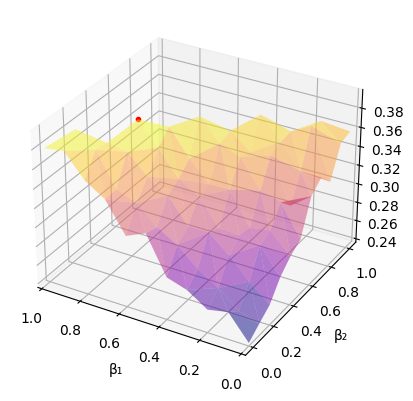

In [135]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
surf = ax.plot_trisurf(x_data, y_data, z_data, linewidth=0.1, alpha=0.5, color='g', cmap='plasma')

ax.set_xlabel("β₁")
ax.set_ylabel("β₂")
ax.set_xlim([1,0])

ax.plot(res[res['obj'] == res['obj'].max()]['heuristic'].values, 
           res[res['obj'] == res['obj'].max()]['real'].values, 
           [res['obj'].max()], c='r', marker='.')

plt.savefig('ml_quality_control_sber.png', dpi=300)

Получается, что наилучшее качество функции отклика с точки зрения целевой функции достигается при следующих коэффициентах:
$$\beta_1=\hat{\alpha}_1=0.7 (Heur)$$
$$\beta_2=\hat{\alpha}_2=0.3 (Real)$$
$$\beta_3=\hat{\alpha}_3=0.0 (Random)$$

Теперь обучим рексистему в симуляторе с функцией отклика с подобранными параметрами.

In [142]:
sim_opt = Simulator(
    user_gen=generator_1,
    item_gen=items_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=CHECKPOINTS_DIR3,
)

In [143]:
resp_func.setWeights([0.3, 0.0, 0.7])

ParametricResponseFunction_b16abafdbe26

In [144]:
simulator_model = UCB(sample = True)

simulator_model.fit(log=synth_indexer.transform(log_df_val.drop('timestamp').limit(1)))

In [145]:
LOG_SCHEMA = st.StructType([
    st.StructField('user_id', st.IntegerType()),
    st.StructField('item_id', st.IntegerType()),
    st.StructField('relevance', st.DoubleType())
])

empty_log = spark.createDataFrame(
    data=spark.sparkContext.emptyRDD(),
    schema=LOG_SCHEMA
)

items_replay = synth_indexer.transform(items_df_comp).cache()

ucb_metrics = []

for i in range(30):
    iter_start = time.time()

    users = sim_opt.sample_users(0.02).cache()
    
    log = sim_opt.get_log(users)
    if log is None:
        log = empty_log
    log = log.cache()

    recs_ucb = simulator_model.predict(
        log=synth_indexer.transform(log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
    recs_ucb = synth_indexer.inverse_transform(recs_ucb).cache()

    resp_ucb = sim_opt.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items_df_comp,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    sim_opt.update_log(resp_ucb, iteration=i)

    ucb_metrics.append(evaluator(resp_ucb))

    simulator_model._clear_cache()
    ucb_train_log = sim_opt.log.cache()
    simulator_model.fit(
        log=synth_indexer.transform(
            ucb_train_log\
                .select('user_id', 'item_id', 'response')\
                .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    resp_ucb.unpersist()
    ucb_train_log.unpersist()

    print(f'Iteration {i} finished with time {time.time() - iter_start} sec.')
    
users = sim_opt.sample_users(0.2).cache()
synth_recs = synth_indexer.inverse_transform(
    simulator_model.predict(
        log=synth_indexer.transform(sim_opt.log),
        k=10,
        users=synth_indexer.transform(users),
        items=items_replay
    )
).cache()
synth_ground_truth = sim_opt.sample_responses(
    recs_df=synth_recs,
    user_features=users,
    item_features=items_df_comp,
    action_models=pipeline
).select('user_id', 'item_id', 'relevance', 'response').cache()
final_metrics_opt = evaluator(synth_ground_truth)

items_replay.unpersist()

Iteration 0 finished with time 25.57187056541443 sec.


Iteration 1 finished with time 21.942259550094604 sec.


Iteration 2 finished with time 21.296812057495117 sec.


Iteration 3 finished with time 21.528837203979492 sec.


Iteration 4 finished with time 21.825632095336914 sec.
Iteration 5 finished with time 22.69623637199402 sec.


Iteration 6 finished with time 22.830013275146484 sec.


Iteration 7 finished with time 21.258943557739258 sec.
Iteration 8 finished with time 22.066858053207397 sec.


Iteration 9 finished with time 21.79737377166748 sec.


Iteration 10 finished with time 22.883914470672607 sec.


Iteration 11 finished with time 22.959402561187744 sec.


Iteration 12 finished with time 21.501333713531494 sec.


Iteration 13 finished with time 22.591466665267944 sec.


Iteration 14 finished with time 23.08862543106079 sec.
Iteration 15 finished with time 25.080543518066406 sec.


Iteration 16 finished with time 23.448610067367554 sec.


Iteration 17 finished with time 22.756891012191772 sec.


Iteration 18 finished with time 24.080568075180054 sec.


Iteration 19 finished with time 23.883764028549194 sec.


Iteration 20 finished with time 24.037561178207397 sec.


Iteration 21 finished with time 24.664106845855713 sec.
Iteration 22 finished with time 24.275689601898193 sec.


Iteration 23 finished with time 24.846373081207275 sec.


Iteration 24 finished with time 25.111175775527954 sec.


Iteration 25 finished with time 23.826118230819702 sec.


Iteration 26 finished with time 24.318200826644897 sec.


Iteration 27 finished with time 23.831905126571655 sec.


Iteration 28 finished with time 32.366053104400635 sec.
Iteration 29 finished with time 20.345972299575806 sec.


DataFrame[item_feature[0]: double, item_feature[1]: double, item_feature[2]: double, item_feature[3]: double, item_feature[4]: double, item_feature[5]: double, item_feature[6]: double, item_feature[7]: double, item_feature[8]: double, item_idx: int]

In [146]:
final_metrics_opt

{'NDCG@10': 0.573569848200266,
 'Precision@10': 0.23216931216931205,
 'RocAuc@10': 0.4917747753422358}

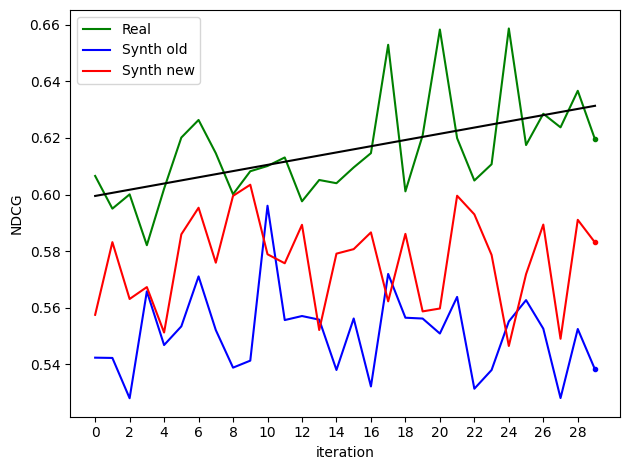

In [150]:
real_learning_metrics_pdf = pd.DataFrame(real_learning_metrics)
ucb_metrics_pdf = pd.DataFrame(ucb_metrics)
ucb_metrics_old_pdf = pd.DataFrame(ucb_metrics_old)
plt.plot(real_learning_metrics_pdf['NDCG@10'], color='g', label='Real')
plt.plot(draw_trend(range(30), real_learning_metrics_pdf['NDCG@10']), color='k')
plt.plot(ucb_metrics_old_pdf['NDCG@10'], color='b', label='Synth old')
plt.plot(ucb_metrics_pdf['NDCG@10'], color='r', label='Synth new')
plt.xlabel('iteration')
plt.ylabel('NDCG')

plt.plot(29, real_learning_metrics_pdf['NDCG@10'][29], 'g.')
plt.plot(29, ucb_metrics_old_pdf['NDCG@10'][29], 'b.')
plt.plot(29, ucb_metrics_pdf['NDCG@10'][29], 'r.')

plt.legend()
plt.xticks(np.arange(0, 30, step=2.0))
plt.tight_layout()

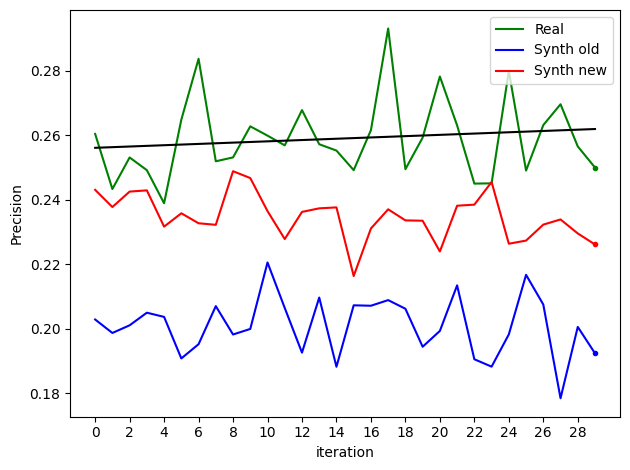

In [151]:
plt.plot(real_learning_metrics_pdf['Precision@10'], color='g', label='Real')
plt.plot(draw_trend(range(30), real_learning_metrics_pdf['Precision@10']), color='k')
plt.plot(ucb_metrics_old_pdf['Precision@10'], color='b', label='Synth old')
plt.plot(ucb_metrics_pdf['Precision@10'], color='r', label='Synth new')
plt.xlabel('iteration')
plt.ylabel('Precision')

plt.plot(29, real_learning_metrics_pdf['Precision@10'][29], 'g.')
plt.plot(29, ucb_metrics_old_pdf['Precision@10'][29], 'b.')
plt.plot(29, ucb_metrics_pdf['Precision@10'][29], 'r.')

plt.legend()
plt.xticks(np.arange(0, 30, step=2.0))
plt.tight_layout()

Как видно из предыдущего графика, кривая обучения рекомендательной системы на новых синтетических данных (с оптимальными параметрами функции отклика) приблизилась к кривой обучения рекомендательной системы на синтетических данных.